In [1]:
import pandas as pd
import numpy as np
import re

## Load the historical price data from CoinDesk

In [62]:
df = pd.read_csv("/Users/kyledunn/Desktop/crypto/coindesk-bpi-USD-close_data-2010-07-17_2018-06-12.csv").iloc[:-2]

In [63]:
df.tail()

,Date,Close Price
2882,2018-06-08 00:00:00,7616.10
2883,2018-06-09 00:00:00,7497.34
2884,2018-06-10 00:00:00,6765.80
2885,2018-06-11 00:00:00,6877.18
2886,2018-06-12 16:51:00,6726.51


### Split out the month-day and year elements seperately (for YoY trend comparisons)

In [64]:
def getMonthAndDay(v):
    return "{}-{}".format(v.Date[5:7], v.Date[8:10])

df['monthday'] = df.apply(getMonthAndDay, axis=1)

def getYear(v):
    return "{}".format(v.Date[0:4])

df['year'] = df.apply(getYear, axis=1)

In [65]:
df['ts'] = df.Date.map(lambda s: pd.to_datetime(s, format="%Y-%m-%d %H:%M:%S") if "-" in s else None)

In [66]:
df.tail()

,Date,Close Price,monthday,year,ts
2882,2018-06-08 00:00:00,7616.10,06-08,2018,2018-06-08 00:00:00
2883,2018-06-09 00:00:00,7497.34,06-09,2018,2018-06-09 00:00:00
2884,2018-06-10 00:00:00,6765.80,06-10,2018,2018-06-10 00:00:00
2885,2018-06-11 00:00:00,6877.18,06-11,2018,2018-06-11 00:00:00
2886,2018-06-12 16:51:00,6726.51,06-12,2018,2018-06-12 16:51:00


### Create year-over-year time series

In [67]:
yearOverYearSeries =\
df\
    .sort_values("ts", ascending=True)\
    .groupby(["year", "monthday"])['Close Price']\
    .agg(lambda df: df.reset_index(drop=True))\
    .unstack()\
    .T[:-1]

yearOverYearSeries.tail()

year,2010,2011,2012,2013,2014,2015,2016,2017,2018
monthday,,,,,,,,,
12-26,0.26,4.02,13.47,765.21,327.16,417.22,902.55,15745.26,NaN
12-27,0.26,4.07,13.42,746.72,315.17,422.52,931.11,15378.28,NaN
12-28,0.28,4.19,13.42,730.47,316.80,421.26,978.01,14428.76,NaN
12-29,0.30,4.17,13.40,745.07,312.44,432.62,969.62,14427.87,NaN
12-30,0.30,4.25,13.45,754.76,309.87,426.14,960.47,12629.81,NaN


In [83]:
%matplotlib inline

#df_p = yearOverYearSeries.drop(["This", "http"], axis=1) #.head(90)

df_norm = pd.DataFrame()
for c in yearOverYearSeries.columns:
    
    if c not in ["2017", "2016", "2018"]:
        continue
    
    maxVal = yearOverYearSeries[c].max()
    df_norm[c] = yearOverYearSeries[c].map(lambda v: v/maxVal)


### 

Text(0,0.5,'% max annual price')

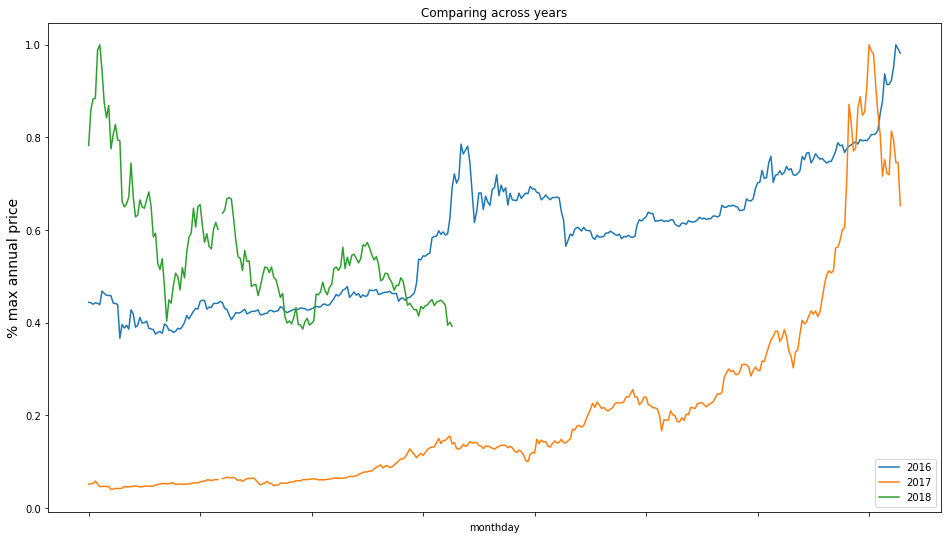

In [84]:
ax = df_norm.plot(figsize=(16, 9), title="Comparing across years")
ax.set_ylabel("% max annual price", size=14)

### Benford testing BTC for erroneous price data

In [91]:
import benford as bf
from IPython.core.display import display, HTML

def runBedford(data, columnName, confidence=[99.99999, 99.99, 99, 99, 99]):
    
    tmp = data.copy()

    # Calculate simple returns
    tmp['p_r'] = tmp[columnName]/tmp[columnName].shift()-1  #simple returns

    # Calculate log-simple returns (this is what get used)
    tmp['l_r'] = np.log(tmp[columnName]/tmp[columnName].shift())  #log returns

    display(HTML('<h3>First digit test - CI: {}</h3>'.format(confidence[0])))
    f1d = bf.first_digits(tmp.l_r, digs=1, decimals=8, confidence=confidence[0])

    display(HTML('<h3>First <i>two</i> digits test - CI: {}</h3>'.format(confidence[1])))
    f2d = bf.first_digits(tmp.l_r, digs=2, decimals=8, confidence=confidence[1])

    display(HTML('<h3>First <i>three</i> digits test - CI: {}</h3>'.format(confidence[2])))
    f3d = bf.first_digits(tmp.l_r, digs=3, decimals=8, confidence=confidence[2])

    display(HTML('<h3>Second digit test - CI: {}</h3>'.format(confidence[3])))
    sd = bf.second_digit(tmp.l_r, decimals=8, confidence=confidence[3])

    display(HTML('<h3>Last two digits test - CI: {}</h3>'.format(confidence[4])))
    l2d = bf.last_two_digits(tmp.l_r, decimals=8, confidence=confidence[4])
    


## Run Benford test for BTC, picking the _highest_ CI values which show anomolies

Initialized sequence with 2744 registries.

Test performed on 2744 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
4             0.09691  0.108965  2.102301


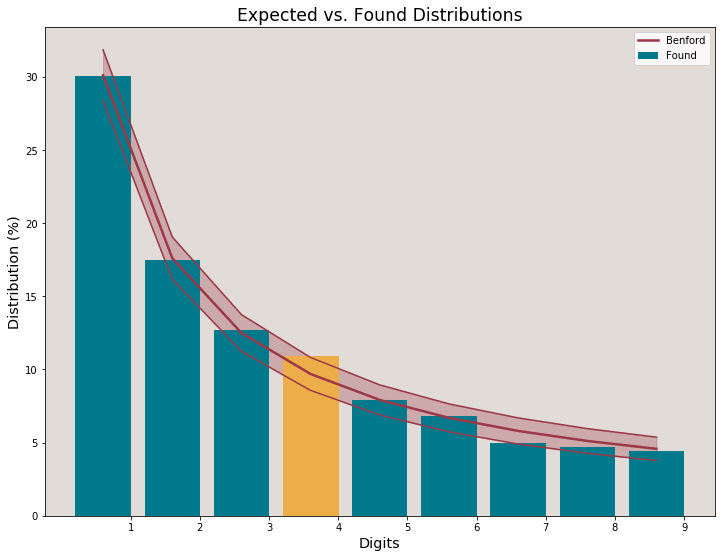

Initialized sequence with 2744 registries.

Test performed on 2744 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_2_Dig                              
59           0.007299  0.012026  2.796774
40           0.010724  0.016035  2.608448
43           0.009984  0.014213  2.131973
11           0.037789  0.045554  2.083180


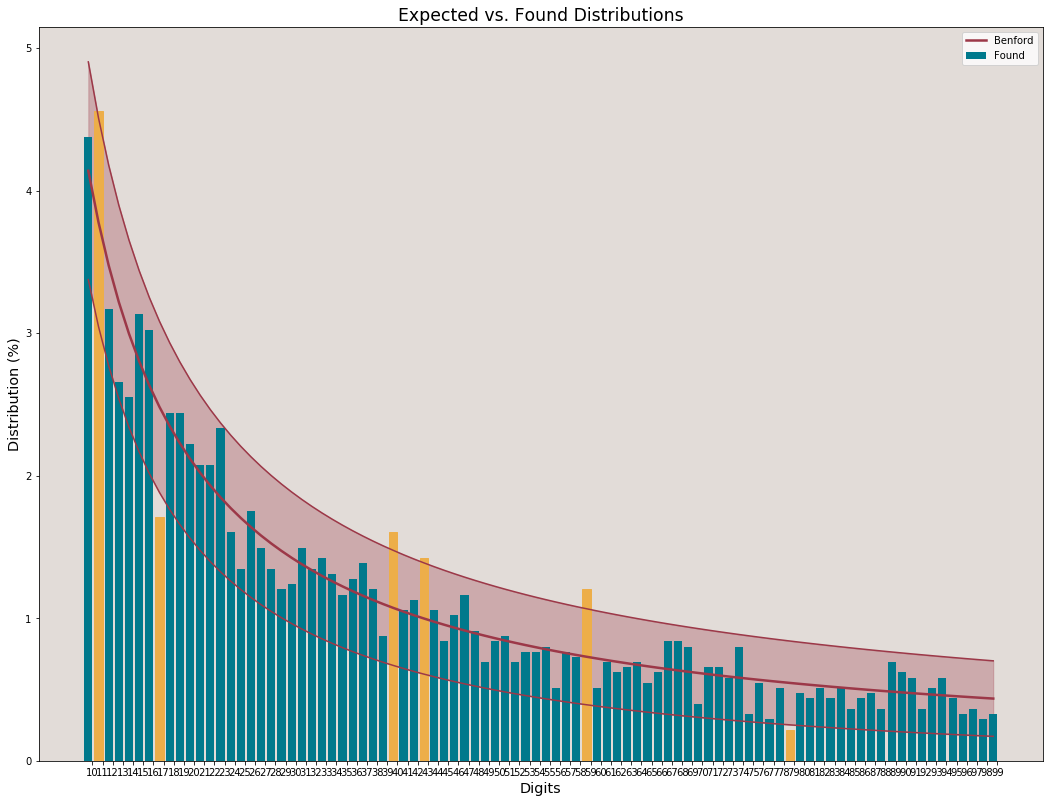

Initialized sequence with 2744 registries.

Test performed on 2744 registries.
Discarded 0 records < 100 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_3_Dig                              
444          0.000977  0.003644  4.166626
512          0.000847  0.003280  4.051019
408          0.001063  0.003644  3.856104
953          0.000455  0.002187  3.802614
416          0.001043  0.002915  2.743797
331          0.001310  0.003280  2.588756
833          0.000521  0.001822  2.568350
474          0.000915  0.002551  2.517925
154          0.002811  0.005466  2.447078
111          0.003895  0.006924  2.394206
230          0.001884  0.004009  2.346282
363          0.001195  0.002915  2.332935
741          0.000586  0.001822  2.282569
715          0.000607  0.001822  2.196952
690          0.000629  0.001822  2.112336
404          0.001074  0.002551  2.071625
673          0.000645  0.001822  2.053428
323          0.001

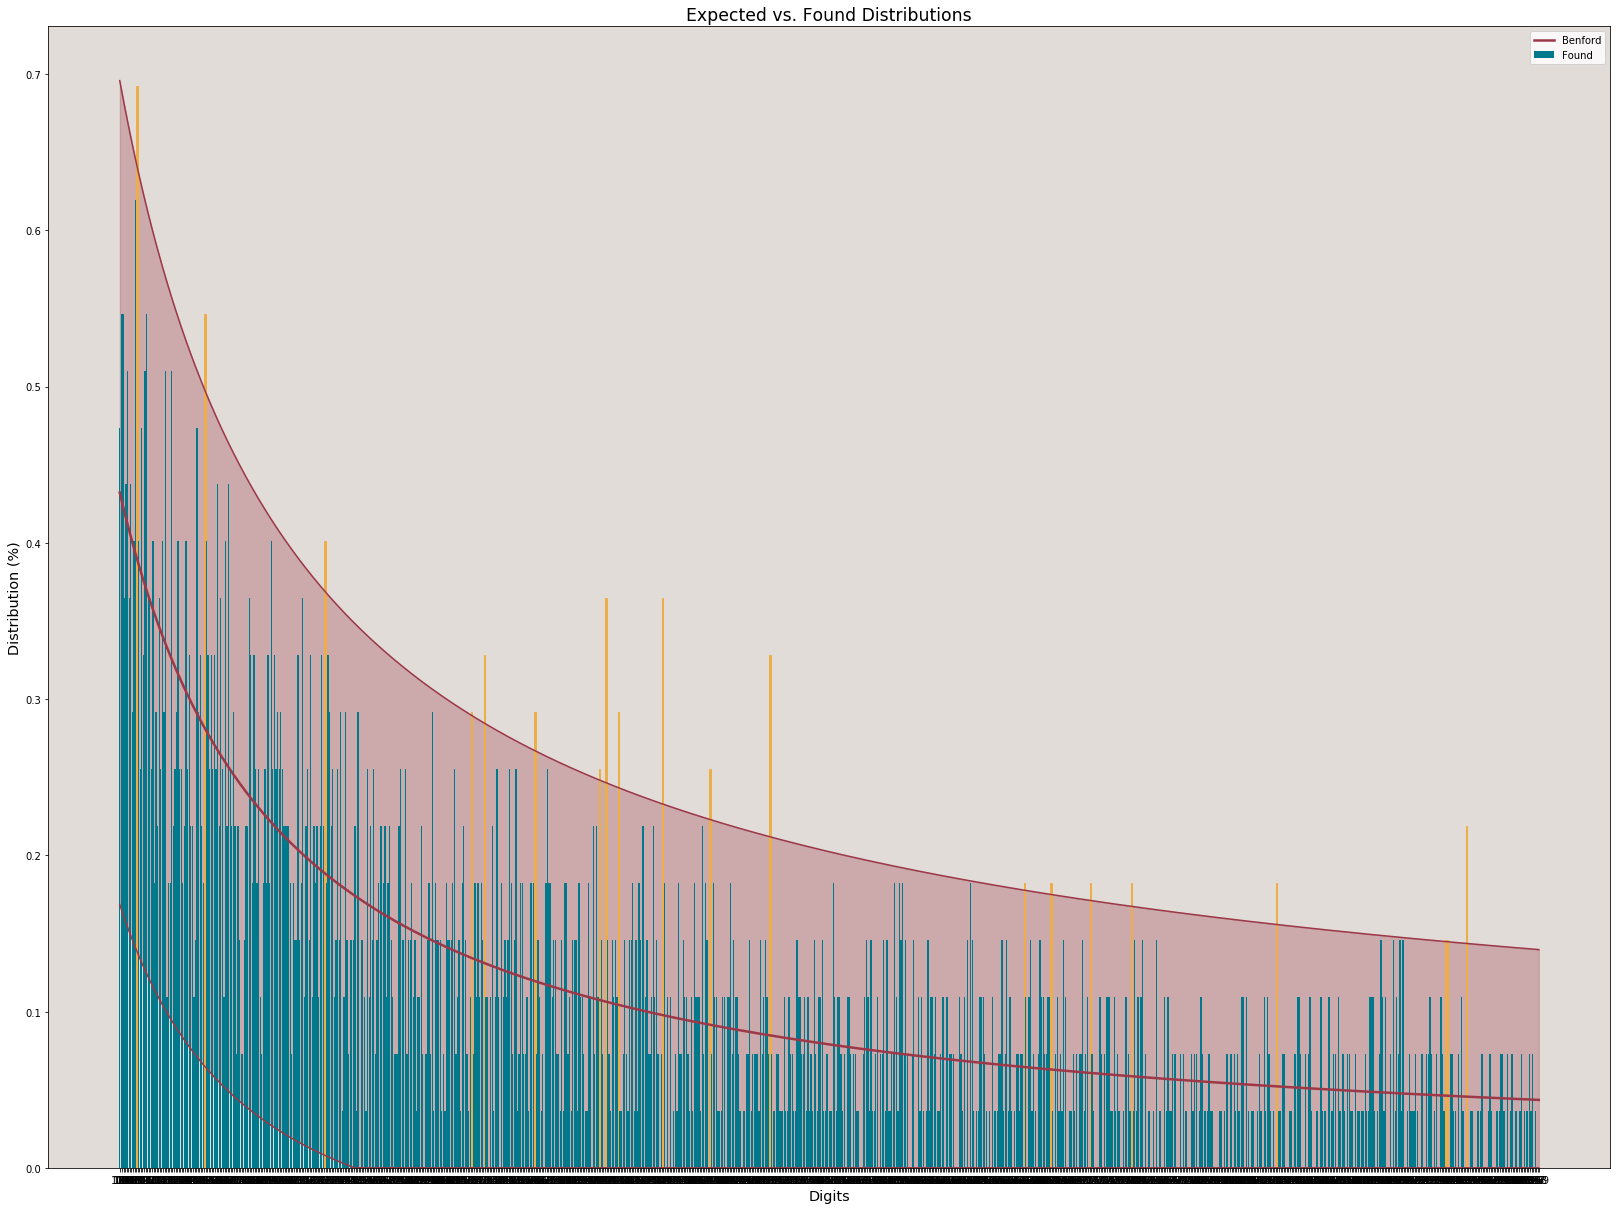

Initialized sequence with 2744 registries.

Test performed on 2744 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

         Expected     Found   Z_score
Sec_Dig                              
1         0.11389  0.124271  1.681725


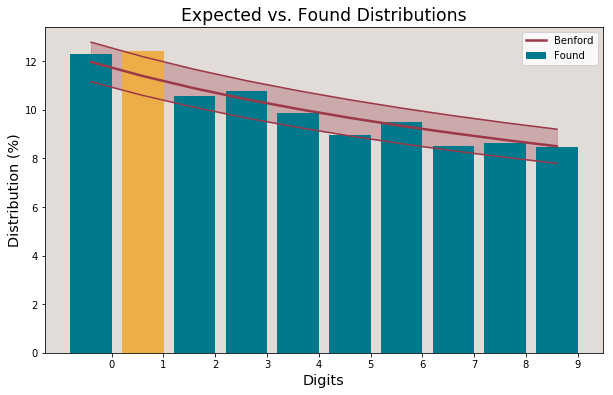

Initialized sequence with 2744 registries.

Test performed on 2744 registries.
Discarded 0 records < 1000 after preparation

The entries with the significant positive deviations are:

            Expected     Found   Z_score
Last_2_Dig                              
82          0.010101  0.014942  2.440378
55          0.010101  0.014577  2.249467
67          0.010101  0.014213  2.058557


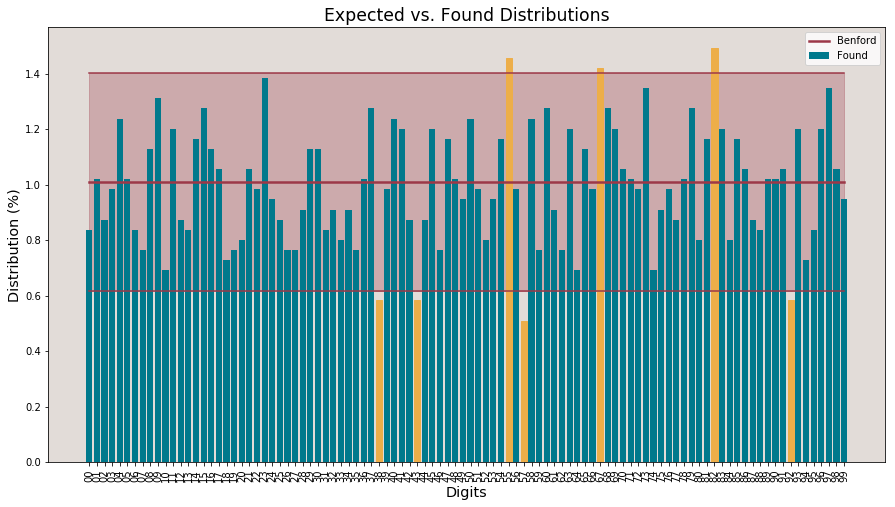

In [92]:
runBedford(df, "Close Price", confidence=[95, 95, 95, 80, 95])

In [93]:
dfe = pd.read_csv("/Users/kyledunn/Desktop/crypto/coindesk-ETH-close_data-2015-08-31_2018-06-12.csv")

## Run Benford test for ETH, picking the _highest_ CI values which show anomolies
(if any)

Initialized sequence with 156 registries.

Test performed on 156 registries.
Discarded 0 records < 1 after preparation.

The entries with the significant positive deviations are:

Empty DataFrame
Columns: [Expected, Found, Z_score]
Index: []


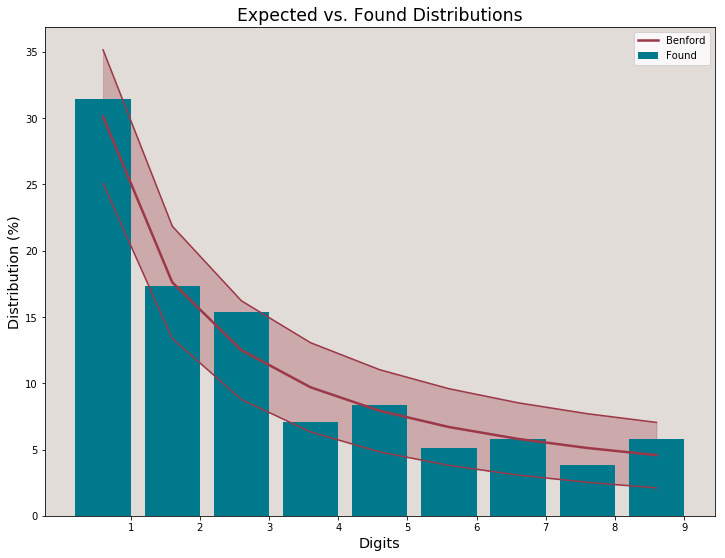

Initialized sequence with 156 registries.

Test performed on 156 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_2_Dig                              
26           0.016390  0.038462  1.855819
78           0.005532  0.019231  1.766903
47           0.009143  0.025641  1.744258


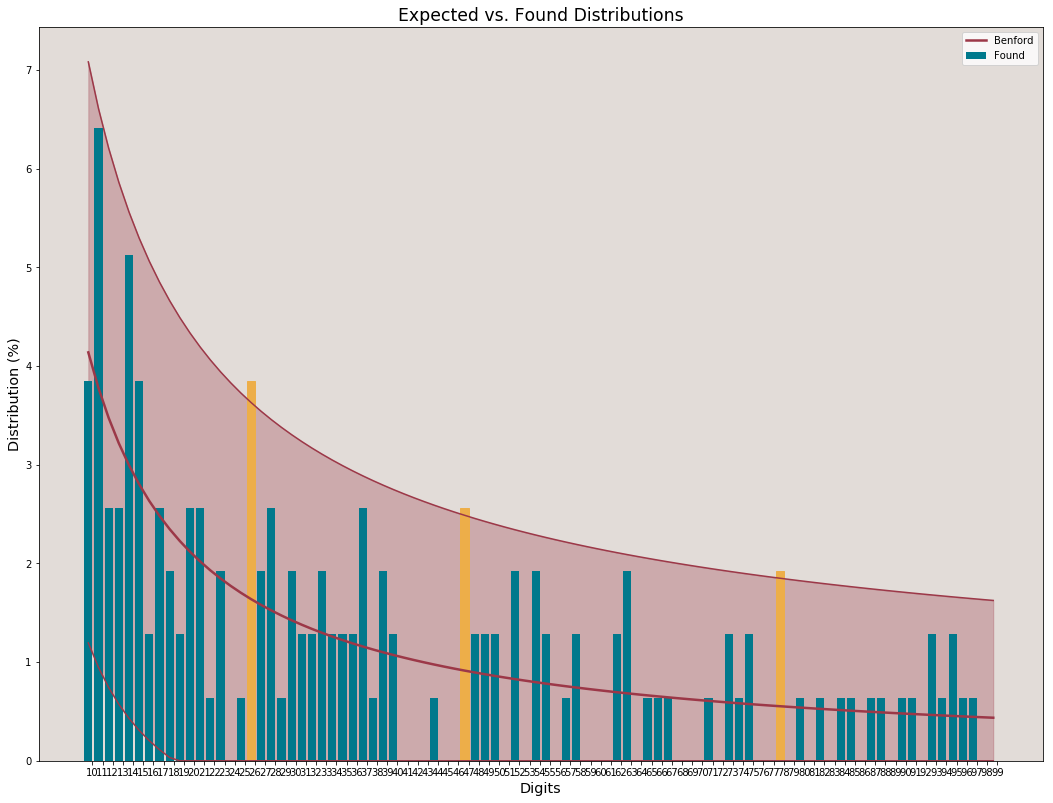

Initialized sequence with 156 registries.

Test performed on 156 registries.
Discarded 0 records < 100 after preparation.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_3_Dig                              
951          0.000456  0.012821  5.355740
119          0.003634  0.032051  5.232973
141          0.003069  0.025641  4.372903
621          0.000699  0.012821  4.214458
527          0.000823  0.012821  3.828703
482          0.000900  0.012821  3.629913
471          0.000921  0.012821  3.579689
377          0.001150  0.012821  3.118905
151          0.002867  0.019231  3.074128
306          0.001417  0.012821  2.722225
276          0.001571  0.012821  2.537281
266          0.001630  0.012821  2.472799
232          0.001868  0.012821  2.241021
212          0.002044  0.012821  2.094033
203          0.002134  0.012821  2.024838


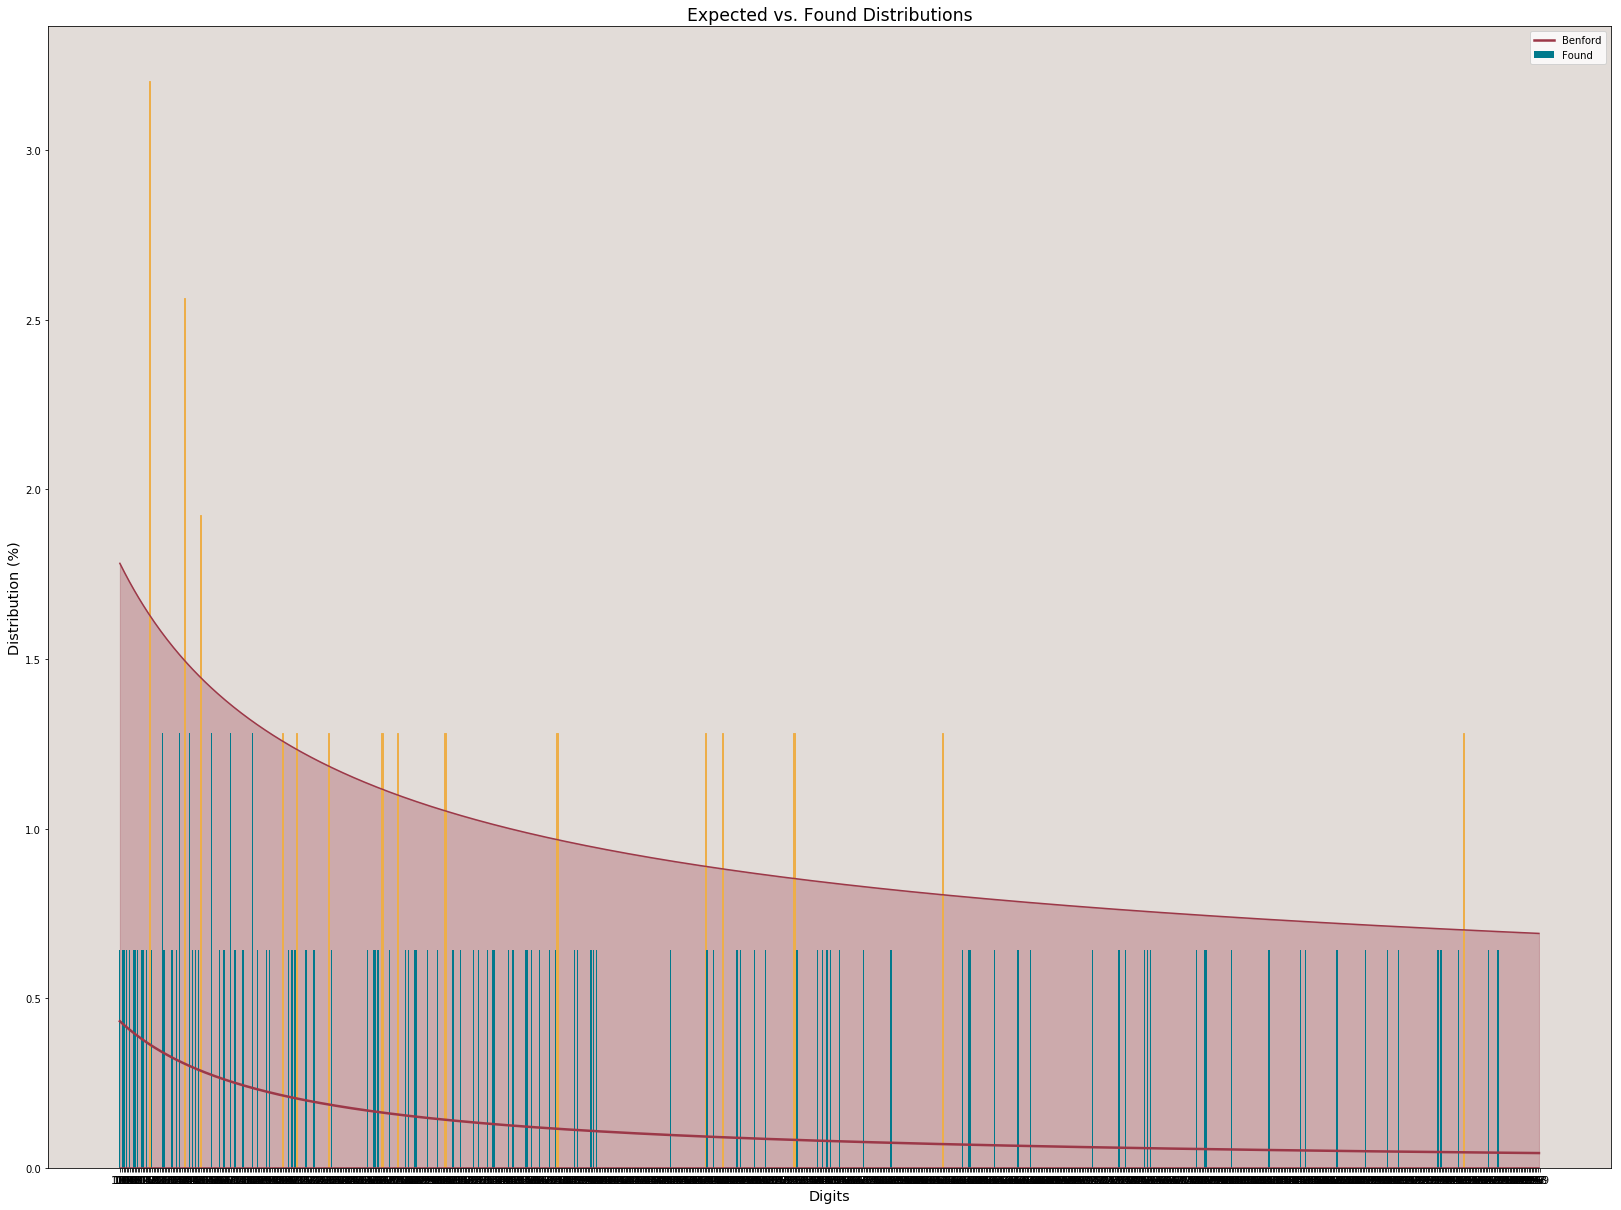

Initialized sequence with 156 registries.

Test performed on 156 registries.
Discarded 0 records < 10 after preparation.

The entries with the significant positive deviations are:

Empty DataFrame
Columns: [Expected, Found, Z_score]
Index: []


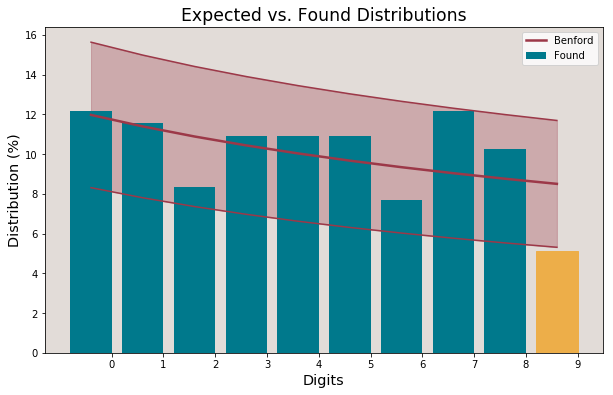

Initialized sequence with 156 registries.

Test performed on 156 registries.
Discarded 0 records < 1000 after preparation

The entries with the significant positive deviations are:

            Expected     Found   Z_score
Last_2_Dig                              
10          0.010101  0.032051  2.341387
15          0.010101  0.032051  2.341387
48          0.010101  0.032051  2.341387
71          0.010101  0.032051  2.341387


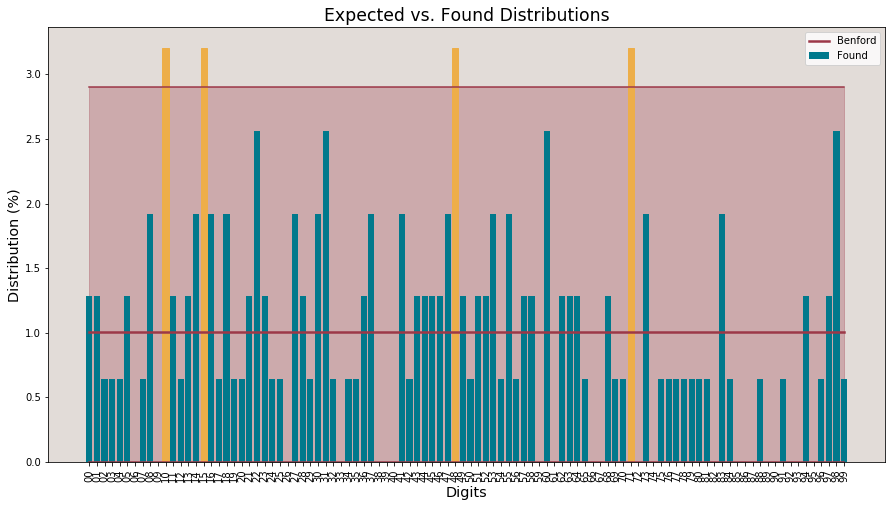

In [96]:
runBedford(dfe, "Close Price", confidence=[80, 90, 95, 80, 95])

### Compare BTC price and Google search interest

In [20]:
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ["Bitcoin"]
pytrends.build_payload(kw_list, cat=0, timeframe='today 5-y', geo='', gprop='')

In [21]:
df_interest = pytrends.interest_over_time()

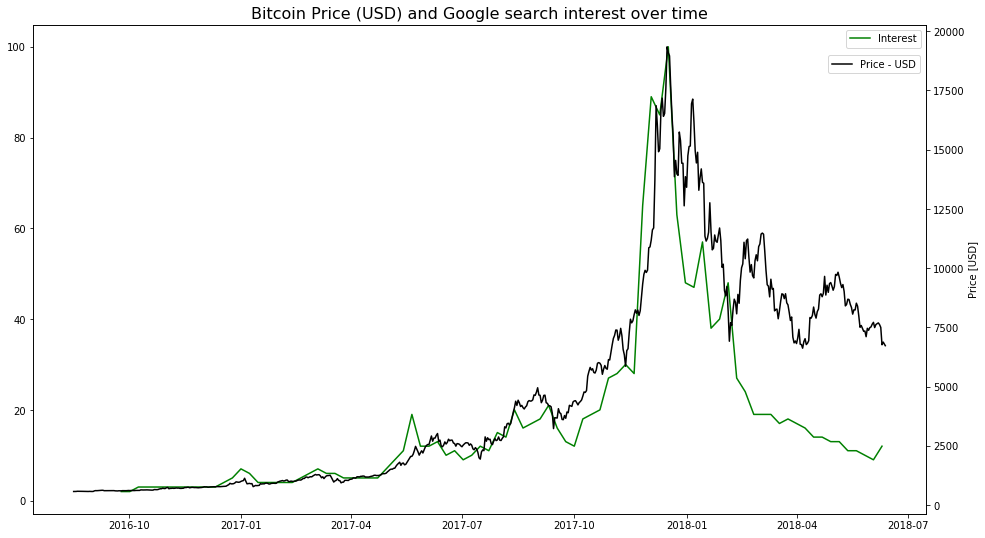

In [113]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(16, 9))
ax = f.subplots(1, 1)

ax.plot(df_interest.index[-90:], df_interest.Bitcoin[-90:], 'green', label="Interest")

ax2 = ax.twinx()

ax2.plot(df['ts'][-665:], df['Close Price'][-665:], 'black', label="Price")
ax2.set_ylabel("Price [USD]")

ax.set_title("Bitcoin Price (USD) and Google search interest over time", size=16)
ax.legend(["Interest"])
ax2.legend(["Price - USD"], loc=[0.89, 0.9])